<a href="https://colab.research.google.com/github/gsasikiran/Semantic-similarity/blob/master/analyzing_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading the word embeddings

In [0]:
import numpy as np
!pip3 install numpy --upgrade

In [0]:
!pip3 install bert-embedding
!pip3 install allennlp
!pip3 install pytorch_transformers

In [0]:
!pip install --upgrade numpy
import scipy

import nltk
nltk.download('punkt')

import tarfile

from nltk.tokenize import word_tokenize
from bert_embedding import BertEmbedding
from allennlp.commands.elmo import ElmoEmbedder

import torch
from pytorch_transformers import *

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing:
* Tokenize sentences
* Assigning corresponding word embeddings
* Create cosine similarity matrix based on the distances between the word embeddings.

In [0]:
class Embeddings:
  
  def __init__(self, sentence_1, sentence_2):
    self.sentence_1 = sentence_1
    self.sentence_2 = sentence_2
    self.tokenized_sent_1 = word_tokenize(self.sentence_1)
    self.tokenized_sent_2 = word_tokenize(self.sentence_2)
    
  def get_elmo_embedding(self):
    '''Creates ELMo word embeddings for the given words
    param: list, list
    returns: ndarray, ndarray
      Returns the ELMo embeddings of the tokens of two sentences'''
    
    elmo = ElmoEmbedder()
    
    elmo_embedding_1 = elmo.embed_sentence(self.tokenized_sent_1)
    elmo_embedding_2 = elmo.embed_sentence(self.tokenized_sent_2)

    return elmo_embedding_1, elmo_embedding_2
    
  def get_bert_embedding(self):
    '''Creates word embeddings taken from BERT language representation
    returns: list, list
      Returns the BERT embeddings of the tokens of two sentences'''
    
    bert_embedding_1  = BertEmbedding().embedding(sentences = self.tokenized_sent_1)
    bert_embedding_2  = BertEmbedding().embedding(sentences = self.tokenized_sent_2)
    
    return bert_embedding_1, bert_embedding_2
    
  def get_gpt_embedding(self):
    '''Creates word embeddings of GPT
    returns: tensor
      Returns the GPT embeddings of the tokens of two sentences'''
    
    model= torch.hub.load('huggingface/pytorch-pretrained-BERT', 'openAIGPTModel', 'openai-gpt')
    tokenizer=torch.hub.load('huggingface/pytorch-pretrained-BERT', 'openAIGPTTokenizer', 'openai-gpt')

    indexed_token_1 = tokenizer.convert_tokens_to_ids(self.tokenized_sent_1)
    indexed_token_2 = tokenizer.convert_tokens_to_ids(self.tokenized_sent_2)
    
    tokens_tensor_1 = torch.tensor([indexed_token_1])
    tokens_tensor_2 = torch.tensor([indexed_token_2])

    gpt_embedding_1 = model(tokens_tensor_1)
    gpt_embedding_2 = model(tokens_tensor_2)

    return gpt_embedding_1, gpt_embedding_2

### Converting Embeddings to list 

In [0]:
class Embedding2Array:
  def elmo(self,embedding):
    ''' Creates the list of arrays of each corresponding word
    parameters
    embedding : ndarray
    returns: list
      Returns the list of elmo embedding of each word 
    '''
    word_array = []
    for i in range(len(embedding[2])):
      word_array.append(embedding[2][i])
    return word_array
    
  def bert(self,embedding):
    ''' Creates the list of arrays of each corresponding word
    param
    embedding: list
    returns: list
      Returns the list of BERT embedding of each word 
    '''
    word_array = []
    for i in range(len(embedding)):
      word_array.append(embedding[i][1][0])
    return word_array
  
  def gpt(self,embedding):
    ''' Creates the list of arrays of each corresponding word
    param
    embedding: tensor
    returns: list
      Returns the list of GPT embedding of each word 
    '''
    word_array = []

    for i in range(embedding[0].shape[1]):
      word_array.append(embedding[0][0][i].tolist())

    return word_array

 ## Processing:
 * Creating a cosine similarity matrix
 * Plotting the similarity matrix based on the cosine matrix from preprocessing class
 * Creating a list of similar words of one sentence for each word in the other sentence.

In [0]:
class SimilarityFunctions:

  def __init__(self, sentence_1, sentence_2, word_array_1, word_array_2):
    self.sentence_1 = sentence_1
    self.sentence_2 = sentence_2
    self.word_array_1 = word_array_1
    self.word_array_2 = word_array_2
  
  def cosine_similarity_matrix(self):
    '''
    Creates a matrix depicting the cosine distances between the words of two sentences
    returns: array
      Similarity matrix of words in two sentences
    '''
    matrix = np.zeros((len(self.word_array_1), len(self.word_array_2)))

    for i in range(0, len(self.word_array_1)):
      for j in range(0, len(self.word_array_2)):
        matrix[i][j]= scipy.spatial.distance.cosine(self.word_array_1[i], self.word_array_2[j])
    return matrix.T
  
  def plot_similarity_matrix(self, title):
    '''Plot the similarity matrix of two sentences
    param:
    title: str
      Labels the plot with the corresponding title
    returns: None
    '''
    x_labels, y_labels = word_tokenize(self.sentence_1), word_tokenize(self.sentence_2)
    similarity_matrix = self.cosine_similarity_matrix()
    sns.heatmap(similarity_matrix, vmin=0, vmax=1, xticklabels=x_labels, yticklabels=y_labels, cmap="YlGnBu", annot = True)
    plt.title(title)
    plt.show()    
  
  def get_similar_words(self):
    '''Prints similar word from second sentence for each word in the first sentence
    returns: list of similar words
    '''

    token_1 = word_tokenize(self.sentence_1)
    token_2 = word_tokenize(self.sentence_2)
    
    similarity_matrix = self.cosine_similarity_matrix()
    
    similar_word_dict = {}
    for row in range(0,len(similarity_matrix[0])):
      
      min_val = min(similarity_matrix.T[row]) #Here min value of transpose is found. To understand it print similarity matrix and find the logic
      index = (np.where(similarity_matrix.T[row] == min_val))[0]
      similar_word_list = []
      
      for i in range(0,len(index)):
        similar_word_list.append(token_2[index[i]])
      similar_word_dict[token_1[row]] = similar_word_list
      
    print('Similar words in two sentences are :', similar_word_dict)

In [0]:
class Main:
  def __init__(self, sentence_1, sentence_2):
    self.first_sentence = sentence_1
    self.second_sentence = sentence_2

  def elmo(self):
    ''' Creates a list of ELMo word embeddings of each sentence
    returns: list, list
      The list of embeddings of words of each sentence
    '''

    embed = Embeddings(self.first_sentence, self.second_sentence)
    embed2array = Embedding2Array()
    first_embedding, second_embedding = embed.get_elmo_embedding()
    first_array, second_array = embed2array.elmo(first_embedding), embed2array.elmo(second_embedding)
    return first_array, second_array

  def bert(self):
    '''Creates a list of BERT word embeddings of each sentence
    returns: list, list
      The list of embeddings of words of each sentence
    '''
    embed = Embeddings(self.first_sentence, self.second_sentence)
    embed2array = Embedding2Array()
    first_embedding, second_embedding = embed.get_bert_embedding()
    first_array, second_array = embed2array.bert(first_embedding), embed2array.bert(second_embedding)
    return first_array, second_array

  def gpt(self):
    '''Creates a list of GPT word embeddings of each sentence
    returns: list, list
      The list of embeddings of words of each sentence
    '''
    embed = Embeddings(self.first_sentence, self.second_sentence)
    embed2array = Embedding2Array()
    first_embedding, second_embedding = embed.get_gpt_embedding()
    first_array, second_array = embed2array.gpt(first_embedding), embed2array.gpt(second_embedding)
    return first_array, second_array

--------------------------------------------------------------------------------

In [0]:
class AnalyzeWordEmbeddings:
  def __init__(self,sentence_1, sentence_2):
    self.sentence_1 = sentence_1
    self.sentence_2 = sentence_2
    
  def bert(self):
    '''Plots similarity matrix using BERT embeddings and returns similar words in both the sentences
    returns: dict
      A dictionary matching the similar words from one sentence to other using BERT embeddings
    '''    
    main = Main(self.sentence_1, self.sentence_2)
    array_1, array_2 = main.bert()
    similarityfunc = SimilarityFunctions(self.sentence_1, self.sentence_2, array_1, array_2)
    similarity_matrix = similarityfunc.cosine_similarity_matrix()
    similarityfunc.plot_similarity_matrix('Similarity plot using BERT embeddings')
    similarityfunc.get_similar_words()
  
  def elmo(self):
    '''Plots similarity matrix using ELMo embeddings and returns similar words in both the sentences
    returns: dict
      A dictionary matching the similar words from one sentence to other using ELMo embeddings
    '''      
    main = Main(self.sentence_1, self.sentence_2)
    array_1, array_2 = main.elmo()
    similarityfunc = SimilarityFunctions(self.sentence_1, self.sentence_2, array_1, array_2)
    similarity_matrix = similarityfunc.cosine_similarity_matrix()
    similarityfunc.plot_similarity_matrix('Similarity plot using ELMo embeddings')
    similarityfunc.get_similar_words()
  
  def gpt(self):
    '''Plots similarity matrix using GPT embeddings and returns similar words in both the sentences
    returns: dict
      A dictionary matching the similar words from one sentence to other using GPT embeddings
    '''    
    main = Main(self.sentence_1, self.sentence_2)
    array_1, array_2 = main.gpt()
    similarityfunc = SimilarityFunctions(self.sentence_1, self.sentence_2, array_1, array_2)
    similarity_matrix = similarityfunc.cosine_similarity_matrix()
    similarityfunc.plot_similarity_matrix('Similarity plot using GPT embeddings')
    similarityfunc.get_similar_words()

--------------------------------------------------------------------------------

In [0]:
first_sentence_1 = "Abstraction and reusability."
second_sentence_1 = "the main advantages to object-oriented programming  is data abstraction, easier maintenance, and re-usability." 

In [0]:
first_sentence_2 = "A man cuts a tomato"
second_sentence_2 = "A woman cuts a potato"

In [0]:
first_sentence_3 = "Flowers blossom in spring."
second_sentence_3 = "Suspension works on spring mechanism."

* Input the sentences and required functions

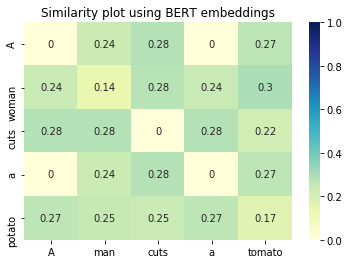

Similar words in two sentences are : {'A': ['A', 'a'], 'man': ['woman'], 'cuts': ['cuts'], 'a': ['A', 'a'], 'tomato': ['potato']}


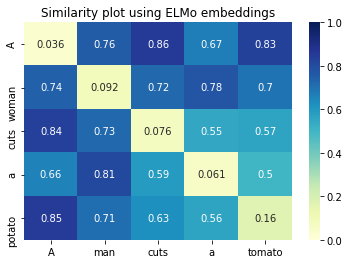

Similar words in two sentences are : {'A': ['A'], 'man': ['woman'], 'cuts': ['cuts'], 'a': ['a'], 'tomato': ['potato']}


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-pretrained-BERT_master


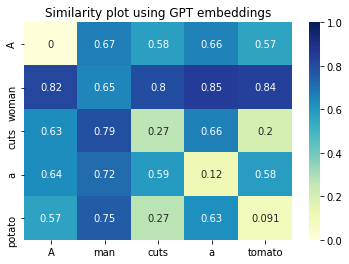

Similar words in two sentences are : {'A': ['A'], 'man': ['woman'], 'cuts': ['cuts'], 'a': ['a'], 'tomato': ['potato']}


In [60]:
analyze_word_embed = AnalyzeWordEmbeddings(first_sentence_2, second_sentence_2)
analyze_word_embed.bert()
analyze_word_embed.elmo()
analyze_word_embed.gpt()

<b> Note:</b> 
* The lighter the map is the more similar the words are...
*First_sentence_1 and second_sentence_1 are the sentences from "Mohler dataset."